In [1]:
import stanza

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import json 

import re

C:\Users\Delbert\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing 

In [57]:
#Read files and convert string to dictionary
df = pd.read_csv("data_tier-1_sample.csv")
df["cohort"] = df["cohort"].apply(json.loads) 

In [58]:
#Create inclusion and exclusion criteria columns
df["inclusion"] = ["None"]*len(df)
df["exclusion"] = ["None"]*len(df)

cohort = df["cohort"]
for x in range(len(cohort)):
    df["inclusion"][x] = cohort[x]["inclusion"]
    df["exclusion"][x] = cohort[x]["exclusion"]

In [59]:
def clean_text(x):
    x = re.sub("-", "", x)
    x = re.sub("\(", " ", x)
    x = re.sub("\)", " ", x)
    return x
    
df["query"] = df["query"].apply(clean_text)

# spaCy 

### Dependency Parsing

In [60]:
import spacy
from spacy.lang.en import English

In [61]:
nlp = spacy.load("en_core_web_sm")
tok_nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(tok_nlp)
# tok = tokenizer(df["query"][1])

In [62]:
def convert(inclusion, exclusion, query):
    doc = nlp(query)
    criterias = inclusion + exclusion

    for criteria in criterias: 
        criteria = clean_text(criteria)
        convert_dict = {}
        for token in doc:
            convert_dict[token.text] = token.i
        criteria = tokenizer(criteria)  
        start = convert_dict[str(criteria[0])]
        span = doc[start : start + len(criteria)]

        with doc.retokenize() as retokenizer:
            retokenizer.merge(span)

    return doc


In [63]:
inclusion_tree = []
exclusion_tree = []
errors = []

for x in range(len(df)):
    try:
        doc = convert(df["inclusion"][x], df["exclusion"][x], df["query"][x])
        inclusion = [clean_text(criteria) for criteria in df["inclusion"][x]]
        exclusion = [clean_text(criteria) for criteria in df["exclusion"][x]]
        for token in doc:
            temp_dict_i = {}
            temp_dict_e = {}
            if token.text in inclusion:
                temp_dict_i["Text"] = token.text
                temp_dict_i["POS"] = token.pos_
                temp_dict_i["DEP"] = token.dep_
                temp_dict_i["Head"] = token.head.text
                if token.i >= 1:
                    temp_dict_i["Left Neighbor"] = str(token.nbor(-1))
                    if token.i >= 2:
                        temp_dict_i["Left 2 Neighbor"] = str(token.nbor(-2))
                        if token.i >= 3:
                            temp_dict_i["Left 3 Neighbor"] = str(token.nbor(-3))
                        else:
                            temp_dict_i["Left 3 Neighbor"] = "None"
                    else:
                        temp_dict_i["Left 2 Neighbor"] = "None"
                else:
                    temp_dict_i["Left Neighbor"] = "None"
                inclusion_tree.append(temp_dict_i)
            if token.text in exclusion:
                temp_dict_e["Text"] = token.text
                temp_dict_e["POS"] = token.pos_
                temp_dict_e["DEP"] = token.dep_
                temp_dict_e["Head"] = token.head.text
                if token.i >= 1:
                    temp_dict_e["Left Neighbor"] = str(token.nbor(-1))
                    if token.i >= 2:
                        temp_dict_e["Left 2 Neighbor"] = str(token.nbor(-2))
                        if token.i >= 3:
                            temp_dict_e["Left 3 Neighbor"] = str(token.nbor(-3))
                        else:
                            temp_dict_e["Left 3 Neighbor"] = "None"
                    else:
                        temp_dict_e["Left 2 Neighbor"] = "None"
                else:
                    temp_dict_e["Left Neighbor"] = "None"
                exclusion_tree.append(temp_dict_e)
    except:
        errors.append(x)
    

In [64]:
len(errors)/len(df)

0.016304347826086956

In [92]:
inclusion = pd.DataFrame(inclusion_tree)
inclusion["Left 2 Neighbor"] = inclusion["Left 2 Neighbor"].astype(str)
inclusion["Left 2 Neighbor"] = inclusion["Left 2 Neighbor"].str.replace("age.*", "age")
exclusion = pd.DataFrame(exclusion_tree)
exclusion["Left 2 Neighbor"] = exclusion["Left 2 Neighbor"].astype(str)
exclusion["Left 2 Neighbor"] = exclusion["Left 2 Neighbor"].str.replace("age.*", "age")

### Inclusion

Text(0.5, 1.0, 'Inclusion Common Dependencies')

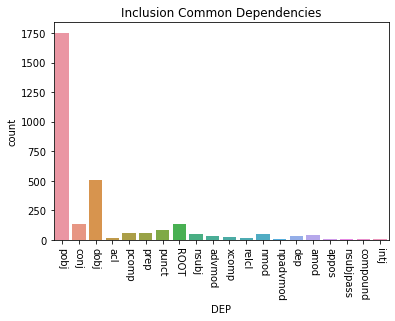

In [34]:
g = sns.countplot(inclusion["DEP"])
plt.xticks(rotation=-90)
plt.title("Inclusion Common Dependencies")

Text(0.5, 1.0, 'Inclusion Common Heads')

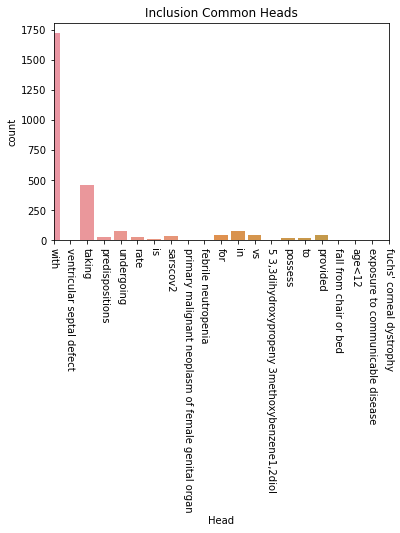

In [498]:
g = sns.countplot(inclusion["Head"])
plt.xticks(rotation=-90)
plt.xlim((0,20))
plt.title("Inclusion Common Heads")

In [120]:
def create_df(df, columns, head, by):
    df_a = df.groupby(by = columns).first().sort_values(by = by, ascending=False).head(head)
    df_b = df.groupby(by = columns).count().sort_values(by = by, ascending=False).head(head)
    df_neighbors = pd.concat([df_a, df_b], axis=1).drop(labels = ["Head"], axis = 1)
    return df_neighbors

inclusion_summary = create_df(inclusion, ["Left Neighbor", "Left 2 Neighbor", "Left 3 Neighbor"], 30, "Left Neighbor")
inclusion_summary

Text  \
Left Neighbor Left 2 Neighbor Left 3 Neighbor                                                                                      
with          people          should                                                                   ventricular septal defect   
              patients        me                                                                   hyperplasia of maxillary bone   
                              for                                                                                         age<68   
              age             with                                                                                comedonal acne   
                              for                                                                            dysplasia of vagina   
vs            new york        in                                                                                         seattle   
              boston          in                                                                                         chicago   
              chicago         in                                                                                       san diego   
              san diego       in                                                                                       san diego   
              seattle         in                                                                                          boston   
to            predispositions genetic                                                                     oropharyngeal aspirate   
taking        currently       disorder of pericardium                                             4methylumbelliferyl chitobiose   
                              communicating hydrocephalus                                                             ofatumumab   
                              concussion with loss of consciousness                                                   calcitriol   
                              contracture of joint of finger                                                        perflubutane   
                              cyclothymia                                                                           mecamylamine   
                              decubitus ulcer of ankle                          10r 10methyl3 6methylpyridin3yl 9,10,11,12tet...   
                              degeneration of lumbosacral intervertebral disc                      n 5'phosphopyridoxyl lalanine   
                              dermatitis caused by radiation                                                          ofatumumab   
                              fracture of radius and ulna                                                monopotassium phosphate   
                              disorder of tooth development                                                               ags004   
                              dissection of internal carotid artery                                                    lidocaine   
                              ehlersdanlos syndrome                            3{6[ 8hydroxyquinoline2carbonyl amino]2thiophe...   
                              endometriosis of uterus                                                                rolofylline   
                              factor v leiden mutation                                                     s,spropylthiocysteine   
                              cholesteatoma                                                              5'sethyl5'thioadenosine   
                              fracture of thoracic spine                                            octyl betadgalactopyranoside   
                              ganglion of wrist                                     5 3,3dihydroxypropeny 3methoxybenzene1,2diol   
                              closed fracture of shaft of tibia                                                         cp122721   
                              ba

### Exclusion

Text(0.5, 1.0, 'Exclusion Common Dependencies')

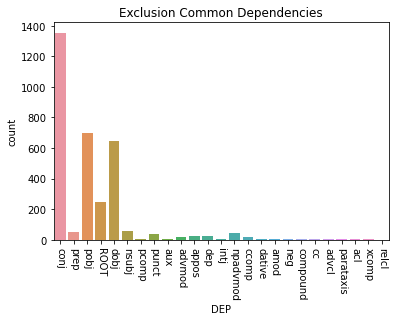

In [500]:
g = sns.countplot(exclusion["DEP"])
plt.xticks(rotation=-90)
plt.title("Exclusion Common Dependencies")

Text(0.5, 1.0, 'Exclusion Common Heads')

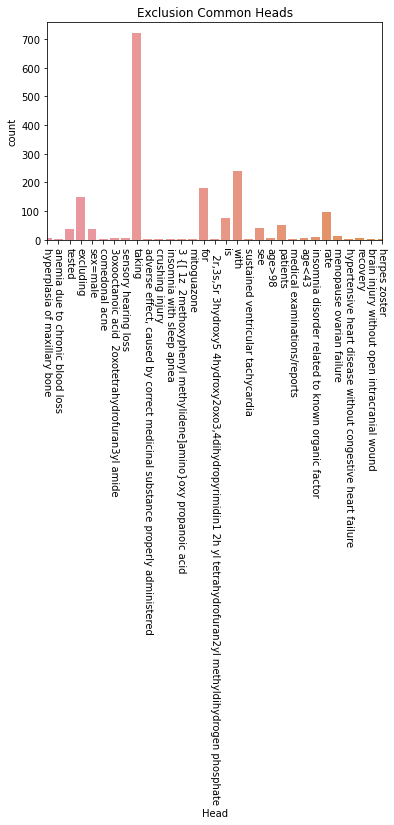

In [516]:
g = sns.countplot(exclusion["Head"])
plt.xticks(rotation=-90)
plt.xlim((0,30))
plt.title("Exclusion Common Heads")

In [123]:
exclusion_summary = create_df(exclusion, ["Left Neighbor", "Left 2 Neighbor", "Left 3 Neighbor"], 50, "Left Neighbor")
exclusion_summary

Text  \
Left Neighbor Left 2 Neighbor                            Left 3 Neighbor                                                                                         
with          diagnosed                                  newly                                                                      generalized osteoarthritis   
taking        but                                        arecoline                                                                                    uk500001   
                                                         benfluorex                                                                                  mosapride   
                                                         bromowillardiine                                                                            mosapride   
                                                         carbamic acid                                                           odecyl hydrogen thiocarbonate   
                                                         dihydroorotic acid                                                                          carprofen   
                                                         eht899                                                                                         idd594   
                                                         etacrynic acid                                               imidazo[2,1a]isoquinoline2carbohydrazide   
                                                         gammaglutamyl[s 2iodobenzyl cysteinyl]glycine                           odecyl hydrogen thiocarbonate   
                                                         gefitinib                                                                                   osanetant   
                                                         indoramin                                                                                      mk0557   
                                                         iso24                                                                   phosphoglycolohydroxamic acid   
                                                         lproline, 1[ 2s 3mercapto2methyl1oxopropyl]4 ph...                                           uk500001   
                                                         nmethyl1 2thiophen2ylphenyl methanamine                                                    lacidipine   
                                                         ozarelix                                                                phosphoglycolohydroxamic acid   
                                                         perazine                                                                                       abxpth   
                                                         phenserine                                                                              isocarboxazid   
                                                         rimacalib                                                        1 3methylphenyl 1hbenzimidazol5amine   
                                                         sadenosyl1,8diamino3thiooctane                                                             lacidipine   
                                                         atrazine glutathione conjugate                                                          penicillamine   
                                                         alks 29                                                                                alloisoleucine   
                                                         telotristat                                                                               4oxoretinol   
                                                         albiglutide                                                  imidazo[2,1a]isoquinoline2carbohydrazide   
              arachnoiditis                              with                                           

### Neighboring

In [15]:
query = df["query"][0]
query

'show me patients with hyperplasia of maxillary bone but not anemia due to chronic blood loss or transjugular intrahepatic portosystemic shunt'

# Forming Heuristic Rules  

In [41]:
import pickle

inclusion = pickle.load(open("inclusion.pickle",'rb'))
exclusion = pickle.load(open("exclusion.pickle",'rb'))

In [42]:
inclusion

,Text,POS,DEP,Head,Left Neighbor,Left 2 Neighbor
0,hyperplasia of maxillary bone,PROPN,pobj,with,with,patients
1,ventricular septal defect,NOUN,pobj,with,with,people
2,abnormal findings on diagnostic imaging of lung,NOUN,conj,ventricular septal defect,and,ventricular septal defect
3,age<68,PROPN,pobj,with,with,patients
4,comedonal acne,PROPN,pobj,with,with,age<68
...,...,...,...,...,...,...
2999,age>=76,PROPN,pobj,with,with,patients
3000,neoplasm of skin,NOUN,pobj,with,with,age>=76
3001,late effect of motor vehicle accident,NOUN,pobj,with,with,patients
3002,portal vein thrombosis,NOUN,pobj,with,with,people


In [6]:
exclusion

,Text,POS,DEP,Head
0,anemia due to chronic blood loss,NOUN,conj,hyperplasia of maxillary bone
1,transjugular intrahepatic portosystemic shunt,NOUN,conj,anemia due to chronic blood loss
2,headache following lumbar puncture,VERB,prep,tested
3,age<=75,NOUN,pobj,excluding
4,sex=male,NOUN,ROOT,sex=male
...,...,...,...,...
3269,pansinusitis,VERB,conj,patients
3270,autologous bone marrow transplant,NOUN,conj,pansinusitis
3271,"carcinoma of lower lobe, bronchus or lung",NOUN,pobj,for
3272,age>98,NOUN,pobj,excluding


In [51]:
for query in df["query"][0:5]:
    print(query, "\n")

show me patients with hyperplasia of maxillary bone but not anemia due to chronic blood loss or transjugular intrahepatic portosystemic shunt 

should people with ventricular septal defect and abnormal findings on diagnostic imaging of lung be tested for headache following lumbar puncture excluding age<=75 and sex=male 

can you show me the recovery rate for patients with age<68 with comedonal acne and hypoplasia of the optic nerve currently taking n 1benzyl3,3,3trifluoro2,2dihydroxypropyl acetamide but not 3oxooctanoic acid  2oxotetrahydrofuran3yl amide 

genetic predispositions to oropharyngeal aspirate 

can you show me the recovery rate for patients with age>=7 with sensory hearing loss and quadriparesis not currently taking 5 2,5dichlorophenyl 2furoic acid but taking 11trans13trans15cisoctadecatrienoic acid 



In [52]:
print(len(df))

1656
